# Домашнее задание 2: DPO и PPO

В этой домашке поближе познакомимся с двумя крайне популярными методами алаймента языковых моделей. В первой части вам предоставится возможность самостоятельно заимплементить DPO c нуля. Во второй части мы уже будем использовать библиотеку TRL и обучим PPO.

Обученные модели можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

## Импорты и вспомогательные функции

In [1]:
# Установим необходимые дополнительные библиотеки

%pip install --quiet datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Необходимые импорты (для обоих частей)
import inspect
import random
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import wandb
from datasets import load_dataset
from huggingface_hub import HfApi, interpreter_login
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    PreTrainedTokenizerBase,
)
from trl import PPOConfig, PPOTrainer, RewardConfig, RewardTrainer

In [3]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) y


In [4]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw2"  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

Homework repository: 'xinyuema/llm-course-hw2'


In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


def disable_dropout_in_model(model):
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0

# Часть 1: DPO

Крайне простой метод, который в свое время произвел фурор, т.к. выгодно выделялся на фоне PPO. В отличие от PPO, требующего отдельно обучать Reward Model, Value Model и больших усилий в имплементации, DPO не требует явной ревард модели, а только датасета с человеческими преференсами вида: промпт, выбранный человеком ответ, отвергнутный человеком ответ. Простота также видна из лосса, по сути это весь метод:
$$
L_\text{DPO}(\pi_{\theta}; \pi_\text{ref}) = -E_{(x, y_w, y_l)\sim D}\left[\log \sigma \left(
\beta \log \frac{\pi_{\theta}(y_w\mid x)}{\pi_\text{ref}(y_w\mid x)} \thinspace
{- \beta \log \frac{\pi_{\theta}(y_l\mid x)}{\pi_\text{ref}(y_l\mid x)}}\right)\right]
$$

где:

- $\pi_{\theta}$ LLM которую мы хотим заалайнить
- $\pi_\text{ref}$ референсная модель для регуляризации, как правило просто начальный чекпоинт
- $D$ датасет с преференсами
- $x$ промпт из датасета $D$
- $y_w$ ответ на промпт $x$ выбранный человеком (или тем кто размечал преференсы, это может быть и большая LLM)
- $y_l$ ответ на промпт $x$ отвергнутый человеком (или тем кто размечал преференсы, это может быть и большая LLM)
- $\beta$ гиперепараметр отвечающий за то, как далеко мы можем отходить от референсной модели

Во время имплементации советум внимательно прочитать оригинальную статью: [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290).

Для файнтюна мы будем использовать модель [HuggingFaceTB/SmolLM-135M-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct), т.к. она маленького размера (поместится на Colab), но при этом умеет достаточно, чтобы увидеть изменения от алаймента. Более того, данная модель даже прошла стадию SFT, а поэтому в отличие от базовой модели (без Instruct) понимает формат чата (chat-template в transformers, дальше разберем) и имеет 'осознание' себя языковым ассистентом.

P.S. Если у вас есть доступ к вычислительным ресурсам типо A100 и больше, вы можете попробовать зафайнтюнить модель большего размера из этой же [линейки](https://huggingface.co/blog/smollm). Будьте внимательны, смотрите, чтобы она была с добавкой Instruct.

In [5]:
MODEL_ID = "HuggingFaceTB/SmolLM-135M-Instruct"
DATASET_ID = "HumanLLMs/Human-Like-DPO-Dataset"

## Подготовка данных [2 балла]

Для начала нужно подготовить данные. В качестве датасета преференсов мы будем использовать [HumanLLMs/Human-Like-DPO-Dataset](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset), который значительно повышает эмоциональность модели, количество используемых эмодзи и в целом снижает строгость следования шаблону "As a conversational AI, I ...".

Чтобы подготовить датасет нужно несколько простых этапов:
1. Привест данные к формату chat-template
2. После применить этот chat-template с помощью 'tokenizer.apply_chat_template'
3. Токенизировать получившиеся данные, попутно обрезав промпт и ответы до нужной длины, если надо.

Внимательно прочитайте [документацию по chat-templates](https://huggingface.co/docs/transformers/chat_templating). Для удобства данные приводят в начале в более верхне-уровневый формат такого вида:
```python
messages = [
    {"role": "system", "content": "You are a helpful assistant focused on technical topics."},
    {"role": "user", "content": "Can you explain what a chat template is?"},
    {"role": "assistant", "content": "A chat template structures conversations between users and AI models..."}
]
```
То есть модели можно задать разные роли, такие как например системный промпт, и в целом структурировать диалог между ассистентом и человеком. Обычно обучение этому происходит на этапе SFT. Данная репрезентация абстрагирует детали (конкретные токены) как этот формат используют разные модели. Чтобы перевести его в неспоредственно текстовый инпут в формате специфичном конкретной модели используется `tokenizer.apply_chat_template`.

In [6]:
# понадобится для подготовки данных
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

In [7]:
dataset = load_dataset(DATASET_ID, split="train")
dataset[0]

README.md:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

data.json:   0%|          | 0.00/28.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10884 [00:00<?, ? examples/s]

{'prompt': 'Oh, I just saw the best meme - have you seen it?',
 'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣",
 'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?"}

Приведите датасет к формату чата, где у промпта роль user, а у ответов assistant, а потом примените чат темплейт:

In [8]:
def apply_chat_template(example: dict[str, str], tokenizer: PreTrainedTokenizerBase) -> dict[str, str]:
    messages = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["chosen"]},
    ]
    prompt = tokenizer.apply_chat_template(messages[:1], tokenize=False, add_generation_prompt=True)
    chosen = tokenizer.apply_chat_template(messages, tokenize=False).split("<|im_start|>assistant\n")[-1]

    messages_rej = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["rejected"]},
    ]
    rejected = tokenizer.apply_chat_template(messages_rej, tokenize=False).split("<|im_start|>assistant\n")[-1]

    return {
        "prompt": prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

In [9]:
dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
dataset[0]

Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

{'prompt': '<|im_start|>user\nOh, I just saw the best meme - have you seen it?<|im_end|>\n<|im_start|>assistant\n',
 'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>\n",
 'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>\n"}

После этих двух этапов данные должны выглядеть так (**обратите внимание на положение <|im_start|>assistant\n**, это важно!):
```
{
    'prompt': "<|im_start|>user\nOh, I just saw the best meme - have you seen it <|im_end|>\n<|im_start|>assistant\n",
    'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>\n",
    'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>\n"
}
```

Токенизируйте датасет с помощью токенизатора, обрезав длину если необходимо. В датасете должны остаться только ID токенов:
```
Dataset({
    features: ['prompt_input_ids', 'chosen_input_ids', 'rejected_input_ids'],
    num_rows: 10884
})
```

Обрезайте промпт слева, а не с конца. Подумайте почему так лучше. **Напишите свой ответ**.<br>
Сохранение ключевой информации: Во многих языковых структурах ключевая информация обычно находится в начале предложения. Например, в английском и многих других языках с субъектно-предикативной структурой основные субъекты и действия обычно располагаются в первой половине предложения. Таким образом, обрезка с конца помогает сохранить больше ключевой контекстной информации, что способствует лучшему пониманию и генерации соответствующего вывода моделью.

Логическая связность: В начале предложений часто содержатся элементы, вводящие тему, которые являются основой для понимания всей структуры предложения. Обрезка с начала может удалить эти важные вводные элементы, делая оставшийся текст трудным для понимания или лишённым логической связности.

Сценарии применения: Особенно в сценариях, таких как системы вопросов и ответов или диалоговые системы, ключевые точки вопроса или диалога часто появляются в первой половине. Сохранение этой части гарантирует, что модель сможет захватить достаточно информации для генерации или предсказания подходящего ответа.

In [10]:
def tokenize_row(
    example: dict,
    tokenizer: PreTrainedTokenizerBase,
    max_prompt_length: int,
    max_completion_length: int
) -> dict:
    # 处理prompt（左截断保留右侧）
    prompt_tokens = tokenizer.encode(example["prompt"])[-max_prompt_length:]  # 关键修改

    # 处理response（右截断保留左侧）
    chosen_tokens = tokenizer.encode(example["chosen"])[:max_completion_length]
    rejected_tokens = tokenizer.encode(example["rejected"])[:max_completion_length]

    return {
        "prompt_input_ids": prompt_tokens,
        "chosen_input_ids": chosen_tokens,
        "rejected_input_ids": rejected_tokens
    }

In [11]:
dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": 256,
        "max_completion_length": None,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)

dataset[0]


Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

{'prompt_input_ids': [1,
  4093,
  198,
  16912,
  28,
  339,
  915,
  3680,
  260,
  1450,
  1169,
  85,
  731,
  457,
  346,
  2269,
  357,
  47,
  2,
  198,
  1,
  520,
  9531,
  198],
 'chosen_input_ids': [10813,
  242,
  220,
  12947,
  28,
  787,
  339,
  8540,
  982,
  17,
  339,
  5248,
  11888,
  288,
  699,
  28,
  732,
  506,
  260,
  1169,
  85,
  563,
  47,
  1431,
  357,
  253,
  17025,
  2644,
  355,
  253,
  31404,
  3223,
  47,
  1691,
  388,
  260,
  9973,
  17,
  15107,
  114,
  113,
  2,
  198],
 'rejected_input_ids': [57,
  5248,
  354,
  6416,
  5290,
  1789,
  1743,
  28,
  339,
  1326,
  982,
  457,
  2143,
  2647,
  355,
  8428,
  30,
  1423,
  28,
  339,
  416,
  1538,
  346,
  351,
  1096,
  335,
  3452,
  29,
  3119,
  284,
  9603,
  32246,
  9411,
  28,
  347,
  876,
  347,
  7400,
  1552,
  335,
  1678,
  14009,
  355,
  5535,
  30,
  13651,
  346,
  702,
  549,
  288,
  1820,
  634,
  7703,
  10026,
  355,
  1692,
  253,
  1542,
  10265,
  282,
  1384,
  

Теперь надо подготовить DataLoader. Для этого надо написать кастомный `collate_fn` который будет делать следующее:
1. Принимать лист примеров с ключами `prompt_input_ids`, `chosen_input_ids`, `rejected_input_ids`.
2. Паддить до максимальной длины в батче по каждому ключу. По итогу `prompt_input_ids` и `chosen_input_ids` могут иметь разную длину, это нормально. Важно, чтобы внутри одинаковых ключей длина была консистентна.
3. Для каждого ключа создавать паддинг маску такого же шейпа, где 0 используется для паддинг-токенов и 1 для токенов последовательности.

Для паддинга дополнительно реализуйте функцию `pad`. В качестве токена используйте `tokenizer.pad_token_id` и 0 для маски. **Опять же, подумайте откуда лучше паддить `prompt_input_ids`?**

In [13]:
def pad(tensors: list[torch.Tensor], padding_value: int = 0, padding_side: str = "right") -> torch.Tensor:
    # 维度验证
    for t in tensors:
        if t.dim() != 1:
            raise ValueError(f"Expected 1D tensor, got {t.dim()}D")

    max_len = max(t.size(0) for t in tensors)
    padded = []
    for t in tensors:
        pad_size = max_len - t.size(0)
        if pad_size <= 0:
            padded.append(t)
            continue

        if padding_side == "right":
            padded_t = torch.cat([t, torch.full((pad_size,), padding_value, dtype=t.dtype, device=t.device)])
        else:
            padded_t = torch.cat([torch.full((pad_size,), padding_value, dtype=t.dtype, device=t.device), t])
        padded.append(padded_t)

    return torch.stack(padded)
def pad_collate_fn(batch: list, pad_token_id: int, max_seq_len: int = MAX_SEQ_LEN):
    # 动态计算每个样本的总长度并截断
    collated = {}
    for key in ["prompt", "chosen", "rejected"]:
        ids = [ex[f"{key}_input_ids"][:max_seq_len] for ex in batch]  # 先截断再填充
        collated[f"{key}_input_ids"] = pad(ids, pad_token_id, "left" if key == "prompt" else "right")
        collated[f"{key}_attn_mask"] = (collated[f"{key}_input_ids"] != pad_token_id).long()
    return collated


dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=2,
    shuffle=True,
    collate_fn=lambda batch: pad_collate_fn(batch, pad_token_id=tokenizer.pad_token_id)
)

In [ ]:
next(iter(dataloader))

{'prompt_input_ids': tensor([[    1,  4093,   198,  1780,   506,   469,  4932,  1502,   282,  2477,
            284,  1701,   536,   346,  2815,   357,    47,     2,   198,     1,
            520,  9531,   198],
         [    2,     2,     2,     2,     2,     1,  4093,   198,  6248,   346,
           4640,  7956, 10026,   355,  7372,  2744,    47,     2,   198,     1,
            520,  9531,   198]]),
 'prompt_attn_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]]),
 'chosen_input_ids': tensor([[26446,   314,   253,  4776,   599,   282,   957,  1029,    17,   339,
           6737,  1643,   957,  4932,  1502,   282,  2477,   314,   641,   519,
           4022,    30,  1385,   506,  1488,   563,   260,  5540,    28,  4122,
           1439,   282,   357,   338,   915, 13531,   288,   549,    30,   339,
           2606,   638,   641,   519,  4022, 12299,  1129,  4308,   351,

## DPO Loss [5 баллов]

Начнем с имплементации самой функции потерь. Она достаточно простая, следуйте формуле дословно и все получится.

In [ ]:
def dpo_loss(
    chosen_logps: torch.Tensor,
    rejected_logps: torch.Tensor,
    ref_chosen_logps: torch.Tensor,
    ref_rejected_logps: torch.Tensor,
    beta: float = 0.1,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # 计算对数概率差异 (公式核心部分)
    policy_diff = (chosen_logps - rejected_logps)
    ref_diff = (ref_chosen_logps - ref_rejected_logps)
    logits = beta * (policy_diff - ref_diff)

    # 计算损失 (应用sigmoid + 负对数)
    loss = -F.logsigmoid(logits).mean()

    # 计算奖励指标
    reward_chosen = (chosen_logps - ref_chosen_logps)
    reward_rejected = (rejected_logps - ref_rejected_logps)
    reward_accuracies = (reward_chosen > reward_rejected).float().mean()
    reward_margins = (reward_chosen - reward_rejected).mean()

    return loss, reward_accuracies, reward_margins

Для удобста также определим отдельную функцию чтобы считать лог-пробы по логитам. Вам нужно вытащить логиты реальных токенов из последовательности. Не забудьте замаскировать лог-пробы промпта перед аггрегацией. Маска здесь уже дана.

Подсказка: внимательно подумайте как соотносятся логпробы и настоящие индексы, иначе рискуете ошибиться на 1

In [21]:

def get_log_prob(logits: torch.Tensor, labels: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    # 确保 logits 和 mask 的序列长度一致
    assert logits.shape[1] == mask.shape[1], f"Logits seq_len ({logits.shape[1]}) != Mask seq_len ({mask.shape[1]})"

    log_probs = F.log_softmax(logits, dim=-1)
    seq_logprobs = torch.gather(log_probs, dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)
    masked_logprobs = seq_logprobs * mask
    return masked_logprobs.sum(dim=-1)


## Обучение DPO [5 баллов]

На всякий случай инициализируем модель, токенизатор и датасет с нуля.
Для простоты ограничимся обычным циклом, без конфигов, классов и прочего.
Вы можете переписать как удобно вам, главное сохранить корректность.

Все нужное у нас уже есть, осталось собрать это все вместе.
Для этого нужно получить логпробы для промпт+выбранный и промпт+отвергнутый ответы.
Не забыть правильно собрать маску для лосса.
В конце обрезать финальные входы для модели до `MAX_SEQ_LEN` (с нужной стороны!).

Обучение занимает примерно час на Colab T4 GPU, 2 минут на H100. В Colab лучше использовать float16 и AMP.
Не забудьте про скейлинг. Для bf16 он не обязателен.

**NB**: для обучения лучше использовать Kaggle Notebooks, т.к. они не вылетают если долго не взаимодействовать с тетрадкой. Их можно оставлять на час без боязни, что они упадут.

In [12]:
BATCH_SIZE = 8  # in colab make it smaller, or implement grad accumulation
NUM_EPOCHS = 1
LR = 5e-5
MAX_SEQ_LEN = 1024  # this also can be adjusted
MAX_PROMPT_LEN = 256 # this also can be adjusted
MAX_COMPLETION_LEN = None
BETA = 1.0

# опционально, если вам хочется логгировать метрики в W&B
ENABLE_WANDB = False

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using '{DEVICE}' device")

Using 'cuda' device


In [ ]:
set_seed(42)

if ENABLE_WANDB:
    wandb.init(project="hw2-rlhf", group="dpo")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    # only if you have A/H100 GPU
    # torch_dtype=torch.bfloat16,
    device_map=DEVICE,
)
model.train()
disable_dropout_in_model(model)

ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    # only if you have A/H100 GPU
    # torch_dtype=torch.bfloat16,
    device_map=DEVICE,
)
ref_model.eval()
disable_dropout_in_model(ref_model)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": MAX_PROMPT_LEN,
        "max_completion_length": MAX_COMPLETION_LEN,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)
dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=False,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


for epoch in range(NUM_EPOCHS):
    losses, accs, margins = [], [], []
    scaler = torch.cuda.amp.GradScaler()   # 修正混合精度初始化[1](@ref)
 # 正确初始化方式

    pbar = tqdm(dataloader, desc="Epoch", leave=False)
    for batch in pbar:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optimizer.zero_grad()

        # ========== 动态截断输入序列 ==========
        max_prompt_len = batch["prompt_input_ids"].shape[1]
        chosen_response = batch["chosen_input_ids"][:, :MAX_SEQ_LEN - max_prompt_len]
        rejected_response = batch["rejected_input_ids"][:, :MAX_SEQ_LEN - max_prompt_len]

        # ========== 拼接输入序列 ==========
        chosen_input_ids = torch.cat([batch["prompt_input_ids"], chosen_response], dim=1)[:, :MAX_SEQ_LEN]
        rejected_input_ids = torch.cat([batch["prompt_input_ids"], rejected_response], dim=1)[:, :MAX_SEQ_LEN]

        # ========== 生成动态mask ==========
        chosen_attention_mask = (chosen_input_ids != tokenizer.pad_token_id).long()
        rejected_attention_mask = (rejected_input_ids != tokenizer.pad_token_id).long()

        # ========== 模型前向传播 ==========
        with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
            # 策略模型
            chosen_outputs = model(chosen_input_ids, attention_mask=chosen_attention_mask, return_dict=True)
            rejected_outputs = model(rejected_input_ids, attention_mask=rejected_attention_mask, return_dict=True)

            # 参考模型
            with torch.no_grad():
                ref_chosen_outputs = ref_model(chosen_input_ids, attention_mask=chosen_attention_mask, return_dict=True)
                ref_rejected_outputs = ref_model(rejected_input_ids, attention_mask=rejected_attention_mask, return_dict=True)

        # ========== 计算对数概率 ==========
        def safe_logprob(logits, labels, mask):
            return get_log_prob(
                logits[:, :-1],  # 排除最后一个预测位置
                labels[:, 1:],   # 目标序列偏移
                mask[:, 1:]      # 对应掩码
            )

        # 策略模型
        policy_chosen_logps = safe_logprob(chosen_outputs.logits, chosen_input_ids, chosen_attention_mask)
        policy_rejected_logps = safe_logprob(rejected_outputs.logits, rejected_input_ids, rejected_attention_mask)

        # 参考模型 (必须补充这部分!)
        ref_chosen_logps = safe_logprob(ref_chosen_outputs.logits, chosen_input_ids, chosen_attention_mask)
        ref_rejected_logps = safe_logprob(ref_rejected_outputs.logits, rejected_input_ids, rejected_attention_mask)

        # ========== DPO损失计算 ==========
        loss, reward_acc, reward_margin = dpo_loss(
            policy_chosen_logps,
            policy_rejected_logps,
            ref_chosen_logps,  # 现在已定义
            ref_rejected_logps, # 现在已定义
            beta=BETA
        )

        # ========== 反向传播 ==========
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # ========== 记录指标 ==========
        losses.append(loss.item())
        accs.append(reward_acc.item())
        margins.append(reward_margin.item())
        pbar.set_postfix({
            "Loss": np.mean(losses[-100:]),
            "Acc": np.mean(accs[-100:]),
            "Margin": np.mean(margins[-100:])
        })
pbar.close()

<ipython-input-46-6618a5cc75dd>:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()   # 修正混合精度初始化[1](@ref)


Epoch:   0%|          | 0/1361 [00:00<?, ?it/s]

Во время обучения reward margins и accuracy должны были расти. Давайте проверим что изменилось после обучения:

In [ ]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)

generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=230, do_sample=True)
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

init_generated_ids = ref_model.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=True)
init_response = tokenizer.batch_decode(init_generated_ids, skip_special_tokens=True)[0]

print("======== BEFORE TUNING ========")
print(init_response)
print()

print("======== AFTER TUNING ========")
print(response)

======== BEFORE TUNING ========
user
What's your morning routine like?
assistant
Morning routine is an important factor in setting up for a productive and healthy morning. Here's my morning routine:

**Pre-Morning Exercise (5-10 minutes)**

1. Stretch or do some yoga to loosen up your muscles and get your blood flowing.
2. Brush your teeth and floss to remove any remaining bacteria and freshen the air.
3. Put on some pajamas or wear a comfortable pair of sneakers.

**Food and Drinks (15-30 minutes)**

1. Prepare breakfast: cook or choose a protein-rich recipe (e.g., a bowl of oatmeal with fruit and nuts) or have some scrambled eggs in a pan and toast.
2. Start with a healthy beverage: juice, coffee, or tea with a sweet and tangy flavor, such as black coffee or orange juice.
3. Eat or opt-in for the day: some people eat as a small snack or choose a meal to satisfy their hunger.

**Morning Routine (30-60 minutes)**

1. Exercise or do bodyweight movements:
	* Start with a morning walk, jo

In [ ]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-dpo", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-dpo", private=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/xinyuema/llm-course-hw2-dpo/commit/f942d8efe66efa720536e474a6b9f114b59898be', commit_message='Upload tokenizer', commit_description='', oid='f942d8efe66efa720536e474a6b9f114b59898be', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xinyuema/llm-course-hw2-dpo', endpoint='https://huggingface.co', repo_type='model', repo_id='xinyuema/llm-course-hw2-dpo'), pr_revision=None, pr_num=None)

# Часть 2: PPO и TRL

Вторая часть будет сильно проще и направлена на то, чтобы познакомиться с самой популярной библотекой для алаймента от huggingface - [TRL](https://huggingface.co/docs/trl/v0.15.0/index). C помощью TRL нужно будет обучить PPO, а для этого вначале обучить Reward Model.

**Лирическое отступление**: PPO имеет парадоксальную репутацию. С одной строны в RL он считается чуть ли не единственным применимым (до сих пор) на практике алгоритмом, который заводится с пол-пинка и на любой задаче. Основной боттлнек для него - данные, чем быстрее симулятор, там больше вероятность, что он вашу задачу решит. Примеров много - так решили Dota 2 или Minecraft. С другой стороны, у алгоритма крайне дурная репутация в плане имплементации с нуля, т.к. есть много важных и маленьких деталей, которые при неправильном исполнении приведут к незаметному, но крайне странному поведению. Дебагать это очень сложно, [чего стоит только этот список](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/) и [такой же для уже RLHF](https://huggingface.co/blog/the_n_implementation_details_of_rlhf_with_ppo), причем часто трюки не пересекаются между доменами. Более того, как раз из-за этого если вы загуглите имплементации PPO с нуля, с большой вероятностью большая часть будет с ошибками.

Поэтому кодить PPO без тесного знакомства и опыта в RL крайне не рекомендуется. Для RLHF лучше использовать TRL или аналоги, для RL лучше использовать [Sample-Factory](https://github.com/alex-petrenko/sample-factory).

## Обучение Reward Model [2 балл]

В отличие от DPO, который выводит апдейт явно, убирая необходимость в награде, для PPO награда нужна, а значит кто-то должен ее выдавать. В общем случае это может быть какая-то простая функция, например равенство с правильным ответом. Для PPO, TRL поддерживает только награды от других моделек (но это поправят в будущем).

Возьмем тот же датасет и попробуем обучить сами. Для обучения нам понадобится preference dataset with implicit prompt ([см. примеры в документации](https://huggingface.co/docs/trl/main/dataset_formats)). То есть должны быть только две колонки: chosen, rejected, каждая содержаящая в себе промпт. По аналогии, это все надо привести в темплейт чата.

Пример:
```python
## Implicit prompt
preference_example = {
    "chosen": [
        {"role": "user", "content": "What color is the sky?"},
        {"role": "assistant", "content": "It is blue."}
    ],
    "rejected": [
        {"role": "user", "content": "What color is the sky?"},
        {"role": "assistant", "content": "It is green."}
    ]
}
```

Подробнее про лосс который оптимизируется [тут](https://rlhfbook.com/c/07-reward-models.html). TRL все сделает за вас.

In [ ]:
def to_implicit_prompt_preferences(example: dict[str, str]) -> dict[str, list[dict[str, str]]]:
    """
    将示例数据转换为隐式提示偏好格式。

    参数:
        example (dict[str, str]): 包含以下键的字典:
            - "prompt": 用户输入的提示
            - "chosen": 助手的优选回答
            - "rejected": 助手的拒绝回答

    返回:
        dict[str, list[dict[str, str]]]: 包含以下键的字典:
            - "chosen": 优选对话的完整消息列表
            - "rejected": 拒绝对话的完整消息列表
    """
    return {
        "chosen": [
            {"role": "user", "content": example["prompt"]},
            {"role": "assistant", "content": example["chosen"]}
        ],
        "rejected": [
            {"role": "user", "content": example["prompt"]},
            {"role": "assistant", "content": example["rejected"]}
        ]
    }

In [ ]:
dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.map(to_implicit_prompt_preferences, remove_columns=["prompt"])
dataset = dataset.train_test_split(train_size=0.9)

Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

Использовать будем ту же модель, обучать только линейный слой поверх. Для модели используйте `AutoModelForSequenceClassification`. Обучите ревард модель с помощь `RewardConfig` и `RewardTrainer`. Одной эпохи должно быть достаточно (даже меньше). Для удобства подгрузите получившуюся модель на хаб.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from trl import RewardTrainer, RewardConfig

# Tokenizer初始化
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token  # 确保 pad_token 设置正确

# 初始化模型
#reward_model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID)
#reward_model.config.pad_token_id = tokenizer.pad_token_id  # 确保模型的 pad_token_id 设置正确
reward_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=1,
    torch_dtype=torch.bfloat16
)
# 训练模型前的配置
# 冻结所有层，除了最后一层
for param in reward_model.base_model.parameters():
    param.requires_grad = False

reward_config = RewardConfig(
    num_train_epochs=4,
    per_device_train_batch_size=16,
    max_length=1024,
    disable_dropout=True,
    learning_rate=2e-5,
    seed=42,
    logging_steps=100,
    report_to="wandb" if ENABLE_WANDB else "none",
)
reward_trainer = RewardTrainer(
    model=reward_model,
    processing_class=tokenizer,
    args=reward_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

# 开始训练
reward_trainer.train()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,0.415900
200,0.083300
300,0.022700
400,0.015300
500,0.010500
600,0.007200
700,0.006900
800,0.007400
900,0.005800
1000,0.005900


Step,Training Loss
100,0.415900
200,0.083300
300,0.022700
400,0.015300
500,0.010500
600,0.007200
700,0.006900
800,0.007400
900,0.005800
1000,0.005900


TrainOutput(global_step=2448, training_loss=0.026948539260166143, metrics={'train_runtime': 819.2334, 'train_samples_per_second': 47.801, 'train_steps_per_second': 2.988, 'total_flos': 0.0, 'train_loss': 0.026948539260166143, 'epoch': 4.0})

Награда для chosen должна быть выше чем для rejected.

In [ ]:
inputs_chosen = tokenizer.apply_chat_template(dataset["test"][0]["chosen"], tokenize=False)
inputs_chosen = tokenizer(inputs_chosen, return_tensors="pt").to(DEVICE)

inputs_rejected = tokenizer.apply_chat_template(dataset["test"][0]["rejected"], tokenize=False)
inputs_rejected = tokenizer(inputs_rejected, return_tensors="pt").to(DEVICE)

score_chosen = reward_model(**inputs_chosen).logits[0].cpu().detach()
score_rejected = reward_model(**inputs_rejected).logits[0].cpu().detach()

In [ ]:
score_chosen, score_rejected

(tensor([3.4844], dtype=torch.bfloat16),
 tensor([-3.4219], dtype=torch.bfloat16))

In [ ]:
# Загрузим reward модель на хаб
#reward_trainer.push_to_hub(f"{REPO_NAME}-reward-model")
#reward_trainer.push_to_hub(f"{REPO_NAME}-reward-model", dataset_name=DATASET_ID, private=True)
reward_trainer.push_to_hub(f"{REPO_NAME}-reward-model", dataset_name=DATASET_ID)

# Загрузим reward модель на хаб

reward_model.push_to_hub(f"{REPO_NAME}-reward-model-module", private=False)


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/xinyuema/llm-course-hw2-reward-model-module/commit/dceff76a4f8622aa0e944881532c7b0c3ed32691', commit_message='Upload LlamaForSequenceClassification', commit_description='', oid='dceff76a4f8622aa0e944881532c7b0c3ed32691', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xinyuema/llm-course-hw2-reward-model-module', endpoint='https://huggingface.co', repo_type='model', repo_id='xinyuema/llm-course-hw2-reward-model-module'), pr_revision=None, pr_num=None)

In [ ]:
help(RewardTrainer.create_model_card)


Help on function create_model_card in module trl.trainer.reward_trainer:

create_model_card(self, model_name: Optional[str] = None, dataset_name: Optional[str] = None, tags: Union[str, list[str], NoneType] = None)
    Creates a draft of a model card using the information available to the `Trainer`.
    
    Args:
        model_name (`str` or `None`, *optional*, defaults to `None`):
            Name of the model.
        dataset_name (`str` or `None`, *optional*, defaults to `None`):
            Name of the dataset used for training.
        tags (`str`, `list[str]` or `None`, *optional*, defaults to `None`):
            Tags to be associated with the model card.



## Обучение PPO [4 балла]

**WARN**: TRL недавно смержили большой рефактор PPO, забыв обновить всю документацию и примеры 🥴🥴🥴. Для правильных примеров смотрите в код, а не в докментацию. Если вам интересно знать виновных в лицо:

<a href="https://ibb.co/zTFL4GTt"><img src="https://i.ibb.co/1tMpm8t4/Screenshot-2025-02-13-at-17-40-48.png" alt="" border="0" /></a>

Для PPO нам понадобится тот же датасет, но уже в формате только prompt. Приведите prompt в чат темплейт и токенизируйте (`tokenizer.apply_chat_template`). Все остальные колонки можно удалить.

В качестве `policy`, `ref_policy` подгрузите SmolLM2-135M-Instruct, в качестве `reward_model`, `value_model` свою обученную ревард модель. Для обучения используйте `PPOConfig` и `PPOTrainer`.

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left")
tokenizer.add_special_tokens({"pad_token": "[PAD]"})
# 加载奖励模型和价值模型（使用相同模型）
value_model = AutoModelForSequenceClassification.from_pretrained(f"{REPO_NAME}-reward-model-module", use_auth_token=True)
reward_model = value_model  # TRL要求value_model和reward_model分离，这里简化处理

policy = AutoModelForCausalLM.from_pretrained(MODEL_ID) # todo()
ref_policy = AutoModelForCausalLM.from_pretrained(MODEL_ID) # todo()
# 数据处理函数
def tokenize(example, tokenizer):
    messages = [{"role": "user", "content": example["prompt"]}]
    input_ids = tokenizer.apply_chat_template(
        messages,
        truncation=True,
        max_length=256,
        padding="max_length",
        add_generation_prompt=True,
        return_tensors="pt"
    )[0]
    return {"input_ids": input_ids}


dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.remove_columns(["chosen", "rejected"])
dataset = dataset.map(tokenize, fn_kwargs={"tokenizer": tokenizer}, remove_columns=dataset.column_names)
dataset = dataset.train_test_split()
training_args = PPOConfig(
    num_train_epochs=1,
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    seed=42,
    logging_steps=25,
    report_to="wandb" if ENABLE_WANDB else "none",
) # todo()
trainer = PPOTrainer(
    args=training_args,
    processing_class=tokenizer,
    model=policy,
    ref_model=ref_policy,
    reward_model=reward_model,
    value_model=value_model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
) # todo()
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

===training policy===


Step,Training Loss


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                             ┃ score                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a fascinating question! As a digital  │ 0.19533143937587738  │
│ If you could only keep three possessions,   │ AI assistant, I don't have personal        │                      │
│ what would they be?                         │ preferences or desires, but I can generate │                      │
│ assistant                                   │ a hypothetical list of three possessions   │                      │
│                                             │ that I believe would be the most valuable  │                      │
│                                             │ and meaningful to me. Please note that     │                      │
│                                             │ this list is not exhaustive, and           │                      │
├─────────────────────────────────────────────┼────────────────────────────────────────────┼──────────────────────┤
│ user                                        │ I'm so sorry to hear that you're going     │ -0.19814527034759521 │
│ I'm so down for that! When were you         │ through a tough time. It's completely      │                      │
│ thinking of doing it?                       │ understandable to feel overwhelmed and     │                      │
│ assistant                                   │ anxious about the future. Here are some    │                      │
│                                             │ suggestions that might help you cope with  │                      │
│                                             │ the stress and anxiety:                    │                      │
│                                             │                                            │                      │
│                                             │ 1. **Take a break**: Sometimes,            │                      │
├─────────────────────────────────────────────┼────────────────────────────────────────────┼──────────────────────┤
│ user                                        │ The elusive "relaxation time"! There are   │ 0.9766409397125244   │
│ What's your go-to hobby to relax after a    │ many ways to unwind and recharge after a   │                      │
│ long day?                                   │ long day. Here are some popular hobbies    │                      │
│ assistant                                   │ that can help you relax and reduce stress: │                      │
│                                             │                                            │                      │
│                                             │ 1. **Yoga or Tai Chi**: These low-impact   │                      │
│                                             │ exercises combine                          │                      │
├─────────────────────────────────────────────┼────────────────────────────────────────────┼──────────────────────┤
│ user                                        │ Quantum physics is a fascinating field     │ 0.17759817838668823  │
│ Can you explain the concept of quantum      │ that deals with the behavior of matter and │                      │
│ physics in simple terms, and provide an     │ energy at the atomic and subatomic level.  │                      │
│ example of how it's used in everyday life?  │ It's a fundamental concept that has        │                      │
│ assistant                                   │ far-reaching implications for our          │                      │
│                                             │ understanding of the universe and has led  │                      │
│                                             │ to numer

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ Here are three possessions that I could      │ -4.872528553009033 │
│ If you could only keep three possessions,   │ keep:                                        │                    │
│ what would they be?                         │                                              │                    │
│ assistant                                   │ 1. **A beautiful, antique piano**: A piano   │                    │
│                                             │ is a unique and valuable possession, with a  │                    │
│                                             │ rich history and a beautiful sound. It's a   │                    │
│                                             │ great investment, as it can appreciate in    │                    │
│                                             │ value over time.                             │                    │
│                                             │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ I'm thinking of doing it. I've been working  │ -4.910090923309326 │
│ I'm so down for that! When were you         │ on this project for years, and it's not only │                    │
│ thinking of doing it?                       │ possible but also crucial to my career.      │                    │
│ assistant                                   │ Here's a brief overview of the challenges    │                    │
│                                             │ and opportunities involved in this project:  │                    │
│                                             │                                              │                    │
│                                             │ **Challenges:**                              │                    │
│                                             │                                              │                    │
│                                             │ 1.                                           │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ Here are some popular hobbies to relax after │ -4.955935001373291 │
│ What's your go-to hobby to relax after a    │ a day:                                       │                    │
│ long day?                                   │                                              │                    │
│ assistant                                   │ 1. **Gardening**: Prune, tend, and harvest   │                    │
│                                             │ your own garden, enjoying the fruits of your │                    │
│                                             │ labor.                                       │                    │
│                                             │ 2. **Gardening**: Prune, tend, and harvest   │                    │
│                                             │ your own garden                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ In quantum physics, the behavior of          │ -4.726993560791016 │
│ Can you explain the concept of quantum      │ particles is governed by principles from     │                    │
│ physics in simple terms, and provide an     │ quantum 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a fascinating question! If I were to   │ -11.391990661621094 │
│ If you could only keep three possessions,   │ keep only three possessions, which would    │                     │
│ what would they be?                         │ they be? Here's a list of the items I would │                     │
│ assistant                                   │ keep:                                       │                     │
│                                             │                                             │                     │
│                                             │ **1. A beautiful, antique piano**           │                     │
│                                             │                                             │                     │
│                                             │ * **Piano**: A 19th                         │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I was thinking of doing it. I was thinking  │ -11.573551177978516 │
│ I'm so down for that! When were you         │ of taking a break from my daily routine and │                     │
│ thinking of doing it?                       │ immersing myself in a new world. I was      │                     │
│ assistant                                   │ thinking of trying to make the most of my   │                     │
│                                             │ downtime, and maybe even finding some       │                     │
│                                             │ inspiration to get me started.              │                     │
│                                             │                                             │                     │
│                                             │ I                                           │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ Here are some of the most enjoyable hobbies │ -11.769864082336426 │
│ What's your go-to hobby to relax after a    │ to relax after a long day:                  │                     │
│ long day?                                   │                                             │                     │
│ assistant                                   │ 1. **Reading**: Choose a book that          │                     │
│                                             │ nourishes your mind and soul. Whether it's  │                     │
│                                             │ a novel, a memoir, or a philosophical       │                     │
│                                             │ treatise, reading can be a great escape     │                     │
│                                             │ from                                        │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ The fascinating world of quantum physics!   │ -11.338619232177734 │
│ Can you explain the concept of quantum      │ Quantum physics deals with the behavior of  │                     │
│ physics in simple terms, and provide an     │ subatomic particles at the smallest scales. │                     │
│ example of how it's used in everyday life?  │ In simple terms, quantum physics is the     │                     │
│ assistant                                   │ study of

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a fascinating question! Here are three │ -17.502683639526367 │
│ If you could only keep three possessions,   │ possessions that I would keep:              │                     │
│ what would they be?                         │                                             │                     │
│ assistant                                   │ **Physical:**                               │                     │
│                                             │                                             │                     │
│                                             │ * A golden golden orb                       │                     │
│                                             │ * A silver-gray feather                     │                     │
│                                             │ * A crystal orb                             │                     │
│                                             │                                             │                     │
│                                             │ **Emotional:**                              │                     │
│                                             │                                             │                     │
│                                             │ * A soft, warm blanket                      │                     │
│                                             │ *                                           │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I was thinking of doing it when I was 12    │ -17.974258422851562 │
│ I'm so down for that! When were you         │ years old. I was a kid, and I loved playing │                     │
│ thinking of doing it?                       │ with blocks and Legos. I loved building and │                     │
│ assistant                                   │ creating things with them. I loved          │                     │
│                                             │ exploring and discovering new things. I     │                     │
│                                             │ loved being creative and having             │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! Here are some of the │ -18.191272735595703 │
│ What's your go-to hobby to relax after a    │ best hobbies to relax after a long day:     │                     │
│ long day?                                   │                                             │                     │
│ assistant                                   │ 1. **Reading**: Whether it's a novel, a     │                     │
│                                             │ book, or a poem, reading can be a balm to   │                     │
│                                             │ your mind and soul. It can help             │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a fascinating topic! Quantum physics,  │ -17.953651428222656 │
│ Can you explain the concept of quantum      │ also known as quantum mechanics, is the     │                     │
│ physics in simple terms, and provide an     │ study of the tiny, subatomic world, which   │                     │
│ example of how it's used in everyday life?  │ is gover

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a delightful question! If I had the    │ -34.54016876220703  │
│ If you could only keep three possessions,   │ chance to only keep three possessions, I    │                     │
│ what would they be?                         │ would have a collection of:                 │                     │
│ assistant                                   │                                             │                     │
│                                             │ 1. **The Golden Acorn**: A small, delicate, │                     │
│                                             │ and ornate trinket that represents my       │                     │
│                                             │ creativity, inspiration, and imagination.   │                     │
│                                             │ It                                          │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I was thinking of doing it when I was 12    │ -34.572227478027344 │
│ I'm so down for that! When were you         │ years old. I was trying to figure out how   │                     │
│ thinking of doing it?                       │ to make my parents do it, and I was trying  │                     │
│ assistant                                   │ to come up with a plan to make it happen. I │                     │
│                                             │ was also trying to figure out how to        │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! Relaxation is        │ -34.56484603881836  │
│ What's your go-to hobby to relax after a    │ essential for our overall well-being, and   │                     │
│ long day?                                   │ there are many wonderful hobbies to do      │                     │
│ assistant                                   │ after a long day. Here are some of my       │                     │
│                                             │ favorite hobbies to do:                     │                     │
│                                             │                                             │                     │
│                                             │ 1. **Reading**: Whether it's fiction,       │                     │
│                                             │ non-fiction                                 │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a fascinating topic! The concept of    │ -34.5423583984375   │
│ Can you explain the concept of quantum      │ quantum physics, also known as quantum      │                     │
│ physics in simple terms, and provide an     │ mechanics, has a simple yet profound        │                     │
│ example of how it's used in everyday life?  │ explanation. Let me break it down in simple │                     │
│ assistant                                   │ terms:                                      │                     │
│                                             │                                             │                     │
│                                             │ **What is quantum physics?**                │                     │
│                                             │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What would you say? If I could only keep    │ -61.676395416259766 │
│ If you could only keep three possessions,   │ three possessions, I'd choose three:        │                     │
│ what would they be?                         │                                             │                     │
│ assistant                                   │ **1. A small, delicate vial of vodka**      │                     │
│                                             │                                             │                     │
│                                             │ * The vodka would be a perfect fit, as it's │                     │
│                                             │ a small,                                    │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I was thinking of doing it. I've been doing │ -61.673038482666016 │
│ I'm so down for that! When were you         │ it for a few years now, and I've come out   │                     │
│ thinking of doing it?                       │ on top. I've been doing it for a few years  │                     │
│ assistant                                   │ now, and I've come out on top. I've been    │                     │
│                                             │ doing it for a few                          │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ Is there a way to relax after a long day?   │ -61.67449951171875  │
│ What's your go-to hobby to relax after a    │ If so, I'd recommend incorporating some of  │                     │
│ long day?                                   │ the following hobbies into your routine:    │                     │
│ assistant                                   │                                             │                     │
│                                             │ 1. **Reading**: Reading is one of the most  │                     │
│                                             │ effective ways to relax after a long day.   │                     │
│                                             │ It can help clear your                      │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ The million-dollar question! Let me break   │ -61.66478729248047  │
│ Can you explain the concept of quantum      │ it down in simple terms.                    │                     │
│ physics in simple terms, and provide an     │                                             │                     │
│ example of how it's used in everyday life?  │ **What is quantum physics?**                │                     │
│ assistant                                   │                                             │                     │
│                                             │ Imagine you have a deck of cards. You can   │                     │
│                                             │ put them in any order, but if you try to    │                     │
│                                             │ put them in a specific order,               │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I think 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a fascinating question! If I could only │ -83.30958557128906 │
│ If you could only keep three possessions,   │ keep three possessions, I would choose a set │                    │
│ what would they be?                         │ of items that would be essential for my      │                    │
│ assistant                                   │ daily life. Here are some of the items I     │                    │
│                                             │ would choose:                                │                    │
│                                             │                                              │                    │
│                                             │ 1. **The Amulet of Knowledge**: A small,     │                    │
│                                             │ delicate                                     │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ I was thinking of doing it in 2019, 2020,    │ -83.31007385253906 │
│ I'm so down for that! When were you         │ and 2021. I was also thinking of doing it in │                    │
│ thinking of doing it?                       │ 2019, 2020, and 2021.                        │                    │
│ assistant                                   │                                              │                    │
│                                             │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ There are many great hobbies to relax after  │ -83.31476593017578 │
│ What's your go-to hobby to relax after a    │ a long day! Here are a few ideas to get you  │                    │
│ long day?                                   │ started:                                     │                    │
│ assistant                                   │                                              │                    │
│                                             │ 1. **Reading**: Choose a book that nourishes │                    │
│                                             │ your mind, heart, and soul. It could be a    │                    │
│                                             │ fiction novel, a non-fiction                 │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ What a fascinating topic! The concept of     │ -83.31033325195312 │
│ Can you explain the concept of quantum      │ quantum physics, also known as the           │                    │
│ physics in simple terms, and provide an     │ principles of quantum mechanics, is often    │                    │
│ example of how it's used in everyday life?  │ misunderstood or oversimplified. I'd be      │                    │
│ assistant                                   │ happy to explain it in simple terms.         │                    │
│                                             │                                              │                    │
│                                             │ **What is quantum physics?**                 │                    │
│                                             │                                              │                    │
│                                             │ QWPD is 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a fascinating question! If I could only │ -98.33387756347656 │
│ If you could only keep three possessions,   │ keep three possessions, I would choose a set │                    │
│ what would they be?                         │ of items that would allow me to maintain a   │                    │
│ assistant                                   │ sense of control and security. Here are some │                    │
│                                             │ of the items I would choose:                 │                    │
│                                             │                                              │                    │
│                                             │ 1. A small, intricately carved wooden        │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ I was thinking of doing it! I was thinking   │ -98.33499145507812 │
│ I'm so down for that! When were you         │ of doing it! I was thinking of doing it! I   │                    │
│ thinking of doing it?                       │ was thinking of doing it! I was thinking of  │                    │
│ assistant                                   │ doing it! I was thinking of doing it! I was  │                    │
│                                             │ thinking of doing it! I was thinking of      │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ There are many great hobbies to help calm    │ -98.33757019042969 │
│ What's your go-to hobby to relax after a    │ your mind and body after a long day. Here    │                    │
│ long day?                                   │ are some popular options:                    │                    │
│ assistant                                   │                                              │                    │
│                                             │ 1. **Reading**: Reading is one of the most   │                    │
│                                             │ effective ways to reduce stress and anxiety. │                    │
│                                             │ It can help you process your thoughts, clear │                    │
│                                             │ your                                         │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ What a great question! The concept of        │ -98.33511352539062 │
│ Can you explain the concept of quantum      │ quantum physics, also known as the           │                    │
│ physics in simple terms, and provide an     │ principles of quantum mechanics, is often    │                    │
│ example of how it's used in everyday life?  │ misunderstood or oversimplified, leading to  │                    │
│ assistant                                   │ a lack of understanding and confusion.       │                    │
│                                             │ Here's a simple explanation and a real-life  │                    │
│                                             │ example to help you understand the basics    │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ user                                        │ What a g

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a fascinating question! If I could     │ -108.02452087402344 │
│ If you could only keep three possessions,   │ only keep three possessions, I'd choose the │                     │
│ what would they be?                         │ following:                                  │                     │
│ assistant                                   │                                             │                     │
│                                             │ 1. **The Grandfather**: A beautiful,        │                     │
│                                             │ antique piano that has been passed down     │                     │
│                                             │ through my family. It's a work of art, a    │                     │
│                                             │ testament to my love                        │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I was thinking of doing it. I've been doing │ -108.02583312988281 │
│ I'm so down for that! When were you         │ it for a while now, and I've been doing it  │                     │
│ thinking of doing it?                       │ for a lot of fun. I've been doing it for a  │                     │
│ assistant                                   │ lot of reasons, but I think it's really     │                     │
│                                             │ interesting to me. I've been                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! There are many       │ -108.02749633789062 │
│ What's your go-to hobby to relax after a    │ hobbies that can help calm your mind and    │                     │
│ long day?                                   │ body after a long day. Here are some        │                     │
│ assistant                                   │ popular ones:                               │                     │
│                                             │                                             │                     │
│                                             │ 1. **Reading**: Whether it's fiction,       │                     │
│                                             │ non-fiction, or a book on a specific topic, │                     │
│                                             │ reading is                                  │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! I'd be happy to      │ -108.02613067626953 │
│ Can you explain the concept of quantum      │ break down the concept of quantum physics   │                     │
│ physics in simple terms, and provide an     │ in simple terms and provide an example of   │                     │
│ example of how it's used in everyday life?  │ how it's used in everyday life.             │                     │
│ assistant                                   │                                             │                     │
│                                             │ **What is Quantum Physics?**                │                     │
│                                             │                                             │                     │
│                                             │ Quantum 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a fascinating question! If I could     │ -113.53582763671875 │
│ If you could only keep three possessions,   │ only keep three possessions, I would choose │                     │
│ what would they be?                         │ the following:                              │                     │
│ assistant                                   │                                             │                     │
│                                             │ 1. A small, intricately carved wooden box   │                     │
│                                             │ with a delicate, lace-like design.          │                     │
│                                             │ 2. A delicate, hand-carved wooden box with  │                     │
│                                             │ a                                           │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I was thinking of doing it. I've been doing │ -113.53683471679688 │
│ I'm so down for that! When were you         │ it for a while now, and I'm excited to      │                     │
│ thinking of doing it?                       │ share with you all the amazing things I've  │                     │
│ assistant                                   │ learned along the way.                      │                     │
│                                             │                                             │                     │
│                                             │ I was born in 1980, and I've always been    │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! There are countless  │ -113.53817749023438 │
│ What's your go-to hobby to relax after a    │ hobbies that can help unwind after a long   │                     │
│ long day?                                   │ day. Here are some popular ones to get you  │                     │
│ assistant                                   │ started:                                    │                     │
│                                             │                                             │                     │
│                                             │ 1. **Reading**: Whether it's fiction,       │                     │
│                                             │ non-fiction, or a combination of both,      │                     │
│                                             │ reading is a                                │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! I'd be happy to      │ -113.53739166259766 │
│ Can you explain the concept of quantum      │ explain the concept of quantum physics in   │                     │
│ physics in simple terms, and provide an     │ simple terms and provide an example of how  │                     │
│ example of how it's used in everyday life?  │ it's used in everyday life.                 │                     │
│ assistant                                   │                                             │                     │
│                                             │ **What is Quantum Physics?**                │                     │
│                                             │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                              ┃ score               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ user                                        │ What a fascinating question! If I could     │ -115.33078002929688 │
│ If you could only keep three possessions,   │ only keep three possessions, I would choose │                     │
│ what would they be?                         │ the following:                              │                     │
│ assistant                                   │                                             │                     │
│                                             │ **1. A small, intricately carved wooden     │                     │
│                                             │ box**                                       │                     │
│                                             │                                             │                     │
│                                             │ The box is a delicate, hand-carved          │                     │
│                                             │ masterpiece of woodwork. It's a             │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ I'm so sad to share my thoughts on this     │ -115.33157348632812 │
│ I'm so down for that! When were you         │ project. I'm sad to share my thoughts on    │                     │
│ thinking of doing it?                       │ this project, but I'm happy to. I'm sad to  │                     │
│ assistant                                   │ share my thoughts on this project, but I'm  │                     │
│                                             │ happy to.                                   │                     │
│                                             │                                             │                     │
│                                             │ I'm sad to share                            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! There are many       │ -115.33277893066406 │
│ What's your go-to hobby to relax after a    │ hobbies that can help reduce stress and     │                     │
│ long day?                                   │ anxiety, and I'll share some of my favorite │                     │
│ assistant                                   │ ones with you. Here are a few:              │                     │
│                                             │                                             │                     │
│                                             │ 1. **Reading**: Whether it's fiction,       │                     │
│                                             │ non-fiction, or a combination of            │                     │
├─────────────────────────────────────────────┼─────────────────────────────────────────────┼─────────────────────┤
│ user                                        │ What a great question! I'd be happy to      │ -115.33210754394531 │
│ Can you explain the concept of quantum      │ explain the concept of quantum physics in   │                     │
│ physics in simple terms, and provide an     │ simple terms and provide an example of how  │                     │
│ example of how it's used in everyday life?  │ it's used in everyday life.                 │                     │
│ assistant                                   │                                             │                     │
│                                             │ **What i

Посмотрим на изменение в ответах. Вполне вероятно, что вы не увидите такого сильного изменения как после DPO. PPO требует гораздо больше ресурсов, правильных гиперпараметров и в целом не так стабилен.

In [15]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)

generated_ids = policy.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

init_generated_ids = ref_policy.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
init_response = tokenizer.batch_decode(init_generated_ids, skip_special_tokens=True)[0]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [16]:
print("======== BEFORE TUNING ========")
print(init_response)
print()

print("======== AFTER TUNING ========")
print(response)

======== BEFORE TUNING ========
user
What's your morning routine like?
assistant
I'm excited to start my morning routine! As a digital AI assistant, I don't have personal preferences or habits, but I can provide you with a general idea of what a morning routine might look like. Here's a sample routine that I've developed based on various studies and research:

**Morning Routine (10-15 minutes)**

1. **Hydrate**: Drink a full glass of water or a herbal tea (e.g., chamomile, peppermint) to start the day.
2. **Eat a nutritious breakfast**: Prepare a healthy breakfast, such as oatmeal with fruit, scrambled eggs with spinach, or Greek yogurt with berries.
3. **Get some morning sunlight**: Spend 10-15 minutes outside in natural light to help regulate your circadian rhythms.
4. **Take a few deep breaths**: Inhale for 1-2 minutes, hold for 2-3 minutes, and exhale for 2-3 minutes.
5. **Stretch or move**: Engage in some light stretching or movement to get your blood flowing and your muscles movi

In [18]:
# Загружаем все на хаб

policy.push_to_hub(f"{REPO_NAME}-ppo")
tokenizer.push_to_hub(f"{REPO_NAME}-ppo")

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/xinyuema/llm-course-hw2-ppo/commit/176b88f8ec223ecb9195ee08d06d8f9c164fba77', commit_message='Upload tokenizer', commit_description='', oid='176b88f8ec223ecb9195ee08d06d8f9c164fba77', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xinyuema/llm-course-hw2-ppo', endpoint='https://huggingface.co', repo_type='model', repo_id='xinyuema/llm-course-hw2-ppo'), pr_revision=None, pr_num=None)

## Анализ модели [2 балл]

Проанализируйте финальный модель (от DPO и PPO).
Постройте графики логпроб для данных из обучающей выборки и сторонних, которые модель не видела.
Подойдет любой не сильно большой датасет с hugging face.

Считает ли финальная модель что данные из обучающей выборки более вероятны?

Попробуйте проанализировать финальную модель (от DPO или PPO). Постройте графики логпроб для данных из обучающей выборки и каких нибудь еще, которые модель не видела. Считает ли финальная модель что данные из обучающей выборки более вероятны?

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

EVAL_DATASET_ID = "Lambent/sonnet_preferences_dpo"
DPO_MODEL_ID = "xinyuema/llm-course-hw2-dpo"


dataset = load_dataset(DATASET_ID)["train"]
eval_dataset = load_dataset(EVAL_DATASET_ID)["train"]

dpo_tokenizer = AutoTokenizer.from_pretrained(DPO_MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token
dpo_model = AutoModelForCausalLM.from_pretrained(DPO_MODEL_ID).to(DEVICE)
BATCH_SIZE = 8
MAX_SEQ_LEN = 1024
MAX_PROMPT_LEN = 256
MAX_COMPLETION_LEN = None

dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
eval_dataset = eval_dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})

dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": MAX_PROMPT_LEN,
        "max_completion_length": MAX_COMPLETION_LEN,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)

eval_dataset = eval_dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": MAX_PROMPT_LEN,
        "max_completion_length": MAX_COMPLETION_LEN,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)

dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=3,
    shuffle=False,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id), # todo(),
)

eval_dataloader = DataLoader(
    eval_dataset.with_format("torch"),
    batch_size=3,
    shuffle=False,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id), # todo(),
)

dpo_model.eval()

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

sonnet_preferences_dpo.json:   0%|          | 0.00/307k [00:00<?, ?B/s]

sonnet_preferences_dpo.jsonl:   0%|          | 0.00/307k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/308 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb)

In [22]:
chosen_logps_list = []
rejected_logps_list = []

pbar = tqdm(dataloader, desc="Evaluating on trainset", leave=False)
for batch in pbar:
    batch = {k: v.to(DEVICE) for k, v in batch.items()}
    # Concatenate the prompt and completion inputs for chosen & rejected
    chosen_chat = torch.concat((batch["prompt_input_ids"], batch["chosen_input_ids"]), dim=-1)
    rejected_chat = torch.concat((batch["prompt_input_ids"], batch["rejected_input_ids"]), dim=-1)
    chosen_chat_mask = torch.concat((batch["prompt_attn_mask"], batch["chosen_attn_mask"]), dim=-1)
    rejected_chat_mask = torch.concat((batch["prompt_attn_mask"], batch["rejected_attn_mask"]), dim=-1)

    # Calculate logits
    chosen_logits = dpo_model(chosen_chat).logits
    rejected_logits = dpo_model(rejected_chat).logits

    # Calculate log probs
    chosen_logps = get_log_prob(chosen_logits, chosen_chat, chosen_chat_mask)
    rejected_logps = get_log_prob(rejected_logits, rejected_chat, rejected_chat_mask)

    chosen_logps_list += chosen_logps.tolist()
    rejected_logps_list += rejected_logps.tolist()

    pbar.set_postfix({"Chosen logps": np.mean(chosen_logps_list), "Rejected logps": np.mean(rejected_logps_list)})

pbar.close()

Evaluating on trainset:   0%|          | 0/3628 [00:00<?, ?it/s]

In [23]:
eval_chosen_logps_list = []
eval_rejected_logps_list = []

pbar = tqdm(eval_dataloader, desc="Evaluating on testset", leave=False)
for batch in pbar:
    batch = {k: v.to(DEVICE) for k, v in batch.items()}
    # Concatenate the prompt and completion inputs for chosen & rejected
    chosen_chat = torch.concat((batch["prompt_input_ids"], batch["chosen_input_ids"]), dim=-1)
    rejected_chat = torch.concat((batch["prompt_input_ids"], batch["rejected_input_ids"]), dim=-1)
    chosen_chat_mask = torch.concat((batch["prompt_attn_mask"], batch["chosen_attn_mask"]), dim=-1)
    rejected_chat_mask = torch.concat((batch["prompt_attn_mask"], batch["rejected_attn_mask"]), dim=-1)

    # Calculate logits
    chosen_logits = dpo_model(chosen_chat).logits
    rejected_logits = dpo_model(rejected_chat).logits

    # Calculate log probs
    chosen_logps = get_log_prob(chosen_logits, chosen_chat, chosen_chat_mask)
    rejected_logps = get_log_prob(rejected_logits, rejected_chat, rejected_chat_mask)

    eval_chosen_logps_list += chosen_logps.tolist()
    eval_rejected_logps_list += rejected_logps.tolist()

    pbar.set_postfix({"Chosen logps": np.mean(eval_chosen_logps_list), "Rejected logps": np.mean(eval_rejected_logps_list)})

pbar.close()

Evaluating on testset:   0%|          | 0/103 [00:00<?, ?it/s]

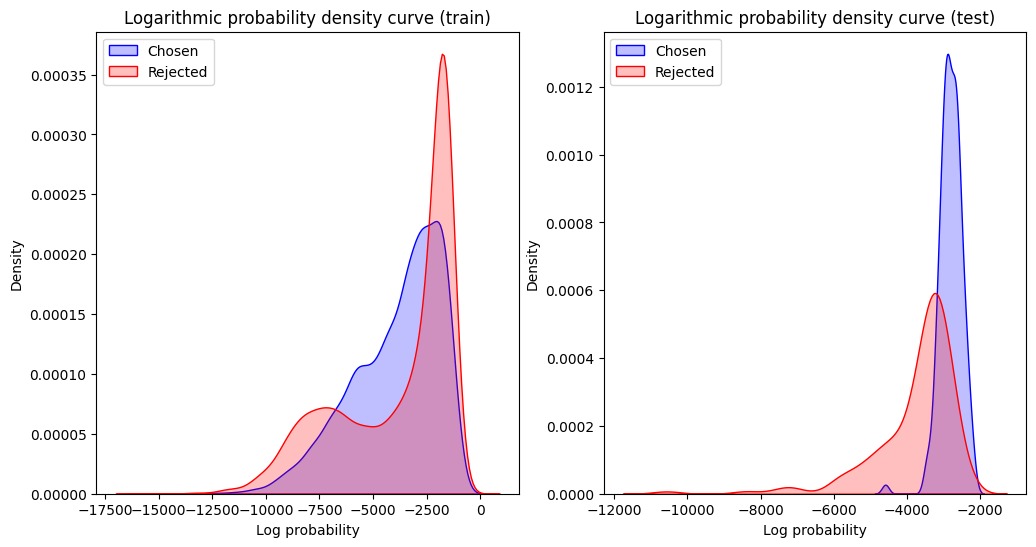

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(chosen_logps_list, ax=axes[0], fill=True, color="blue", label="Chosen")
sns.kdeplot(rejected_logps_list, ax=axes[0], fill=True, color="red", label="Rejected")
axes[0].set_title('Logarithmic probability density curve (train)')
axes[0].set_xlabel('Log probability')
axes[0].legend(loc='upper left')
sns.kdeplot(eval_chosen_logps_list, ax=axes[1], fill=True, color="blue", label="Chosen")
sns.kdeplot(eval_rejected_logps_list, ax=axes[1], fill=True, color="red", label="Rejected")
axes[1].set_title('Logarithmic probability density curve (test)')
axes[1].set_xlabel('Log probability')
axes[1].legend(loc='upper left')
plt.show()

# Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Оформить репозитории на 🤗 (можно сделать коллекцию, так как у нас 3 репозитория): карточка модели с описанием задания, репортом качества и примерами генерации **[2 балла]**

https://huggingface.co/collections/xinyuema/collactions-of-dpo-and-ppo-67e6b35827a5b4436d5f33a8

# Специальный раздел для проверяющего

In [25]:
device = torch.device("cuda")

DPO_REPO_NAME = f"{REPO_NAME}-dpo"
PPO_REPO_NAME = f"{REPO_NAME}-ppo"
REWARD_MODEL_REPO_NAME = f"{REPO_NAME}-reward-model"

tokenizer = AutoTokenizer.from_pretrained(DPO_REPO_NAME)
check_model = AutoModelForCausalLM.from_pretrained(DPO_REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

In [26]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]

text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = check_model.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
response = tokenizer.decode(generated_ids, skip_special_tokens=True)[0]

TypeError: argument 'ids': 'list' object cannot be interpreted as an integer